Наш дорогой Георгий разметил 10 партий, поэтому теперь мы можем поиграться с классическими моделями для определения интересности ходов. Начнём с так называемой "базы"

Хотя перед этим, пару слов, почему мы будем оптимизировать `precision`, а не какую-либо другую метрику.

В нашем случае `accuracy` не даст ровным счётом ничего: **положительный класс гораздо реже встречается, чем отрицательный.**

Высокий `recall` будет означать, что иногда наша модель будет неинтересные моменты помечать интересными, а это **потеря внимания зрителя, минус просмотры, минус деньги, короче плохо**.

А вот высокий `precision` звучит отлично: **если модель пометила момент как интересный, то он действительно интересный**. Да, некоторые интересные моменты мы пропустим, но кого это волнует, когда у нас под рукой 6 миллиардов партий в открытой базе LiChess? К тому же мы пока что экспериментируем, и эта модель будет неплохой отправной точкой

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score

In [3]:
data = pd.read_csv('train.csv')
data

,delta_score,deviation_from_pv,threats_to_opponent,threats_from_opponent,legal_moves_diff,sacrifice,advantage_change,mate_distance,king_under_attack,is_capture,is_check,is_checkmate,cnt_promotion,is_used_promotion,is_castling,target
0,5.000000,0,0,0,0,0,0,0.0,0,False,False,False,0,False,False,0
1,-2.333333,1,0,0,0,0,0,0.0,0,False,False,False,0,False,False,0
2,14.333333,0,0,0,0,0,0,0.0,0,False,False,False,0,False,False,0
3,31.000000,0,1,1,1,0,0,0.0,0,False,False,False,0,False,False,0
4,56.666667,0,1,1,0,0,0,0.0,0,True,False,False,0,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,15.000000,0,1,1,-13,0,0,0.0,1,False,True,False,0,False,False,0
775,-19.333333,0,1,0,0,0,0,0.0,0,False,False,False,0,False,False,0
776,33.000000,0,2,1,-12,0,0,0.0,1,False,True,False,0,False,False,0
777,1.333333,0,1,1,0,0,0,0.0,0,False,False,False,0,False,False,0


In [4]:
X = data.drop('target', axis=1)
y = data['target']

# scl = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# X_train = scl.fit_transform(X_train)
# X_test = scl.transform(X_test)

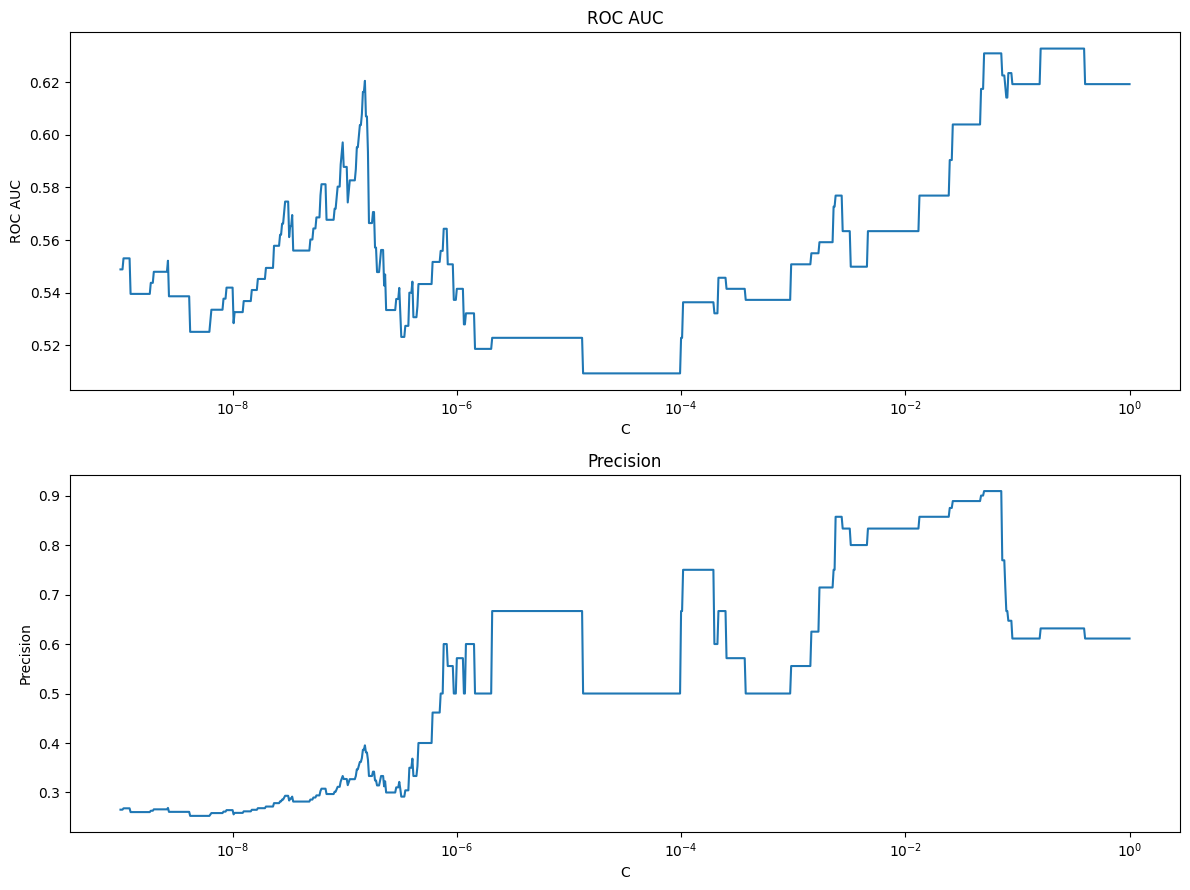

Best C (by precision): 0.050431594871713586
Best C (by auc-roc): 0.16114142772530166


In [5]:
import matplotlib.pyplot as plt

Cs = np.logspace(start=-9, stop=0, num=1000)
rocs = []
prs = []

for C in Cs:
    model = LinearSVC(C=C)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    pr = precision_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)
    rocs.append(auc_roc)
    prs.append(pr)

rocs = np.array(rocs)
prs = np.array(prs)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 9))

ax[0].plot(Cs, rocs)
ax[0].set_title('ROC AUC')
ax[0].set_xlabel('C')
ax[0].set_ylabel('ROC AUC')
ax[0].set_xscale('log')  # Логарифмическая шкала на оси x

ax[1].plot(Cs, prs)
ax[1].set_title('Precision')
ax[1].set_xlabel('C')
ax[1].set_ylabel('Precision')
ax[1].set_xscale('log')  # Логарифмическая шкала на оси x

plt.tight_layout()
plt.show()

print(f'Best C (by precision): {Cs[np.argmax(prs)]}')
print(f'Best C (by auc-roc): {Cs[np.argmax(rocs)]}')

Такая себе модель, конечно. Дело в том, что мы не учитываем специфику данных. Линейная модель пытается предсказать является ли ход интересным. Но разметка данных показывает скорее "входит ли ход в интересный момент".

Прежде чем перейти к другим идеям, давайте применим тяжёлую артиллерию: случайный лес

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict((X_test))
pr = precision_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
print(f'Precision: {pr}')
print(f'AUC-ROC: {auc_roc}')

Precision: 0.6666666666666666
AUC-ROC: 0.7054281171928232


Результат почти такой же. В общем, нужно думать, как учитывать последовательный характер данных.

Хочется накапливать информацию от предыдущих ходов и по накопленной информации определять, является ли текущий ход интересным, а точнее, входит ли текущий ход в промежуток интересного момента.

Очевидно, речь идёт про рекуррентную нейронную сеть.

Но для начала нужно разбить датасет на игры, потому что наша сетка не должна "помнить" ходы из предыдущих партий:

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

ModuleNotFoundError: No module named 'torch'

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [7]:
moves_sequences = []
labels = []

for i in range(1, 11):
    train_part = pd.read_csv(f'marked_up/tmp/{i}.csv')
    X_part, y_part = train_part.drop('target', axis=1), train_part['target']

    moves_sequences.append(X_part)
    labels.append(y_part)

Теперь сконструируем модель:

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [9]:
# Параметры модели
input_size = 15  # Размерность векторов в последовательности
hidden_size = 50  # Размерность скрытого состояния LSTM
num_layers = 2  # Количество слоев LSTM
num_classes = 2  # Количество классов (1 или 0)
num_epochs = 20  # Количество эпох обучения
batch_size = 32  # Размер батча
learning_rate = 0.001  # Скорость обучения

In [10]:
dataset = SequenceDataset(moves_sequences, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

NameError: name 'SequenceDataset' is not defined